# Predicting daily energy consumption
Northern Illinois hourly power consumption data acquired from https://www.kaggle.com/robikscube/hourly-energy-consumption?select=NI_hourly.csv  
Weather data (daily min and max temperatures) acquired from https://www.ncdc.noaa.gov/

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]

In [2]:
mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
consumption_data = pd.read_csv('./NI_hourly.csv', parse_dates=['Datetime'], date_parser=mydateparser)
consumption_data.columns = ['datetime', 'consumption']

In [3]:
# adding the data column
consumption_data['date'] = consumption_data['datetime'].dt.date.astype('datetime64')

In [4]:
# grouping the data by date to get the daily consumption
daily_consumption = consumption_data.groupby('date').sum()

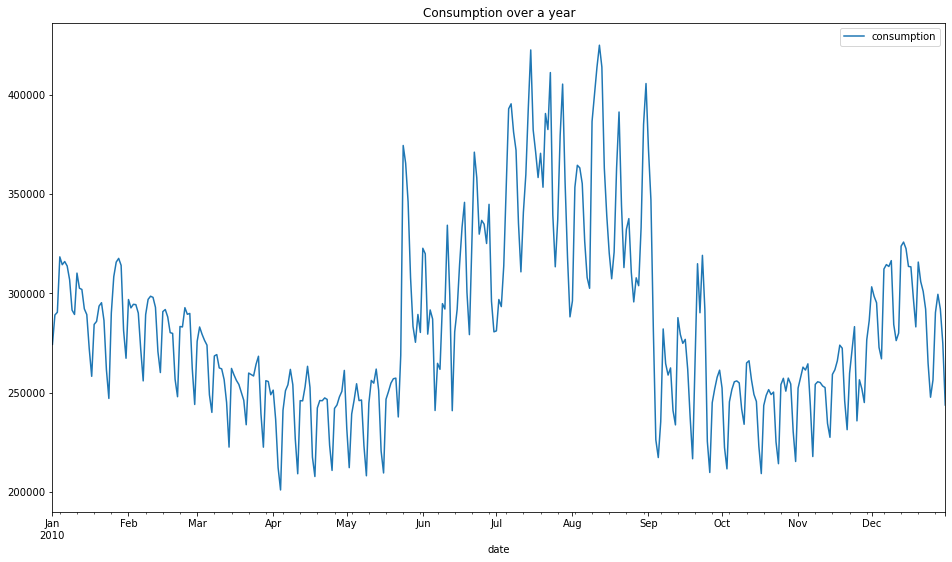

In [25]:
daily_consumption.tail(365).plot(title="Consumption over a year");

We can see a significant drop on the last day, looks like a partial reading that should be ignored

In [6]:
daily_consumption.tail()

,consumption
date,
2010-12-28,299529.0
2010-12-29,292097.0
2010-12-30,274924.0
2010-12-31,243774.0
2011-01-01,10042.0


In [7]:
# dropping outlier
daily_consumption.drop(pd.to_datetime('2011-01-01'), inplace=True)

In [8]:
daily_consumption.describe()

,consumption
count,2436.000000
mean,280769.017241
std,41773.959126
min,198158.000000
25%,253701.250000
50%,273573.500000
75%,302444.750000
max,481122.000000


In [9]:
weather = pd.read_csv('./NI_weather.csv', parse_dates=['DATE'])
# getting the average readings per day from all weather stations
weather_agg = weather.groupby('DATE').mean()
weather_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2555 entries, 2004-01-01 to 2010-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    2552 non-null   float64
 1   TMIN    2552 non-null   float64
dtypes: float64(2)
memory usage: 59.9 KB


In [10]:
 # fill data for missing days with readings from previous day 
 weather_agg.fillna(method='ffill', inplace=True)

In [11]:
# merging the consumption data with the min and max daily temperatures
dataset = daily_consumption.merge(weather_agg, right_index=True, left_index=True, how='inner')[['TMIN','TMAX','consumption']]
dataset.columns = ['temp_min', 'temp_max', 'consumption']
dataset.sample(10)

,temp_min,temp_max,consumption
2010-02-06,25.0,32.0,271746.0
2005-10-15,35.0,69.0,228164.0
2010-10-15,36.0,63.0,245567.0
2004-11-28,31.0,41.0,227605.0
2006-05-30,68.0,90.0,359465.0
2008-08-29,53.0,82.0,341406.0
2006-06-23,55.0,76.0,296202.0
2005-11-16,18.0,36.0,289210.0
2004-12-23,2.0,17.0,305763.0
2005-03-29,34.0,69.0,249133.0


In [12]:
#!pip install holidays
import holidays
us_holidays = holidays.UnitedStates()

In [13]:
# adding business day indication based on weekdays and US holidays
dataset['business_day'] = dataset.index.to_series().dt.date.apply(lambda x: np.is_busday(x) and x not in us_holidays)
dataset['day_of_week'] = dataset.index.to_series().dt.dayofweek

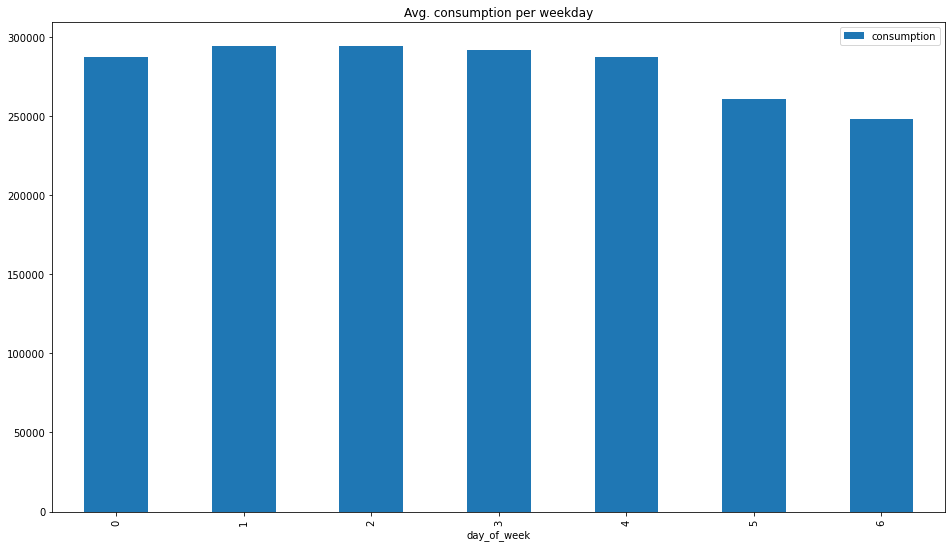

In [14]:
dataset[['day_of_week','consumption']].groupby('day_of_week').mean().plot(kind="bar", title="Avg. consumption per weekday");

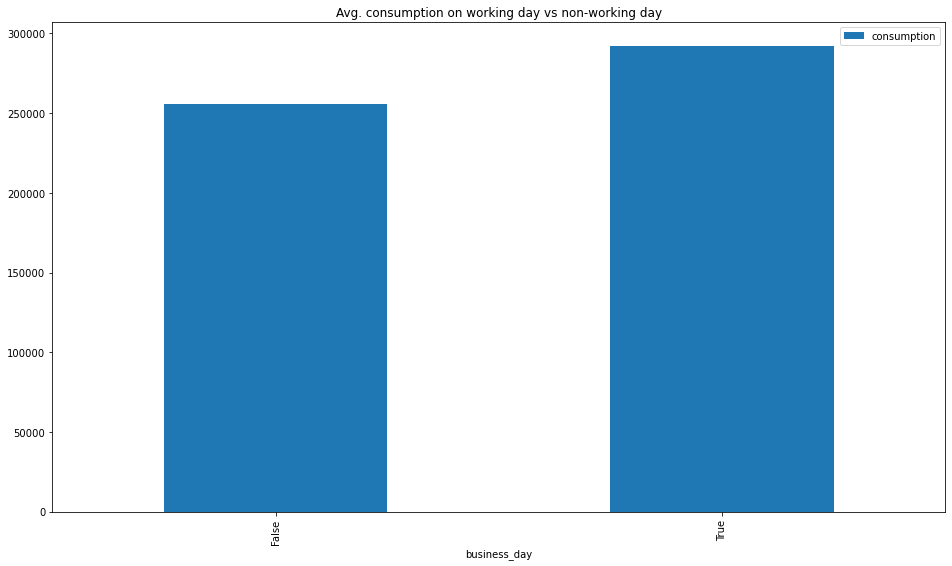

In [15]:
dataset[['business_day','consumption']].groupby('business_day').mean().plot(kind="bar", title="Avg. consumption on working day vs non-working day");

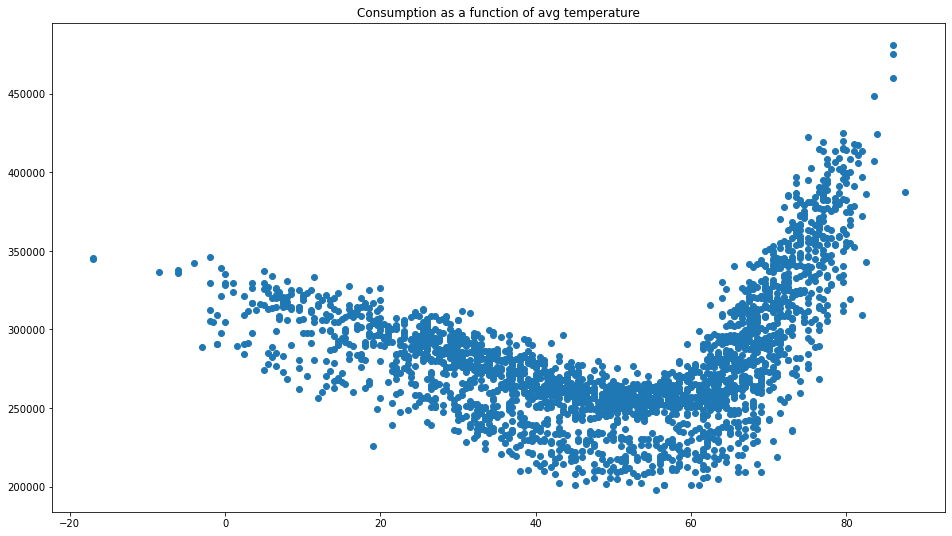

In [16]:
plt.scatter(x=(dataset.temp_max + dataset.temp_min)/2, y=dataset.consumption)
plt.title('Consumption as a function of avg temperature');

We can see that the consumption is higher when it's colder but much higher when it's warmer. I assume this is because cooling is based more on electricity and heating uses more natural gas.

## Learning
I'll be using the temperature features as numerical features and apply scaling and polynomial transformations.  
For the categorical features of business day and day of the week I'll apply the one-hot encoding transformation.

In [17]:
from sklearn.model_selection import train_test_split, cross_val_score

numeric_features = ['temp_min','temp_max']
categorical_features = ['business_day','day_of_week']

X = dataset[numeric_features + categorical_features]
y = dataset.consumption
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[('poly',PolynomialFeatures()),
                                      ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [19]:
%%time
from sklearn.linear_model import LinearRegression
lr = Pipeline([('preprocessor', preprocessor), ('model', LinearRegression())])
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

CPU times: user 71.6 ms, sys: 17.3 ms, total: 88.9 ms
Wall time: 78.7 ms


0.7206057428692847

In [20]:
scores = cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

22712.287362345796

## Trying Ridge regression with parameter tuning

In [26]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
ridge = Pipeline([('preprocessor', preprocessor), ('model', Ridge())])
gs_ridge = GridSearchCV(ridge, param_grid=param_grid)
gs_ridge.fit(X_train, y_train)
gs_ridge.score(X_test, y_test)

CPU times: user 29 s, sys: 582 ms, total: 29.6 s
Wall time: 7.74 s


0.8623472427062122

In [27]:
scores = cross_val_score(gs_ridge, X, y, cv=5, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

16349.319925002692

In [28]:
gs_ridge.best_params_

{'model__alpha': 0.01584893192461111, 'preprocessor__num__poly__degree': 13}

## Adding the temperatures of the day before

In [29]:
import datetime
weather_agg['tomorrow'] = weather_agg.index.to_series().apply(lambda x: x + datetime.timedelta(days=1))
dataset_w_yesterday = dataset.merge(weather_agg, right_on='tomorrow', left_index=True, how='inner')
dataset_w_yesterday.rename(columns = {'TMAX': 'temp_max_yesterday', 'TMIN': 'temp_min_yesterday'}, inplace=True)

In [30]:
numeric_features = ['temp_min','temp_max','temp_max_yesterday','temp_min_yesterday']
X = dataset_w_yesterday[numeric_features + categorical_features]
y = dataset_w_yesterday.consumption
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [31]:
gs_ridge2 = GridSearchCV(ridge, param_grid=param_grid)
gs_ridge2.fit(X_train, y_train)
gs_ridge2.score(X_test, y_test)

0.8398790031741706

In [32]:
scores = cross_val_score(gs_ridge2, X, y, cv=5, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

16328.24834328677